Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
from time import time
from sklearn import datasets
from scipy.special import logsumexp
from sklearn.preprocessing import binarize, LabelBinarizer
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.validation import check_is_fitted, _check_sample_weight
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline

Base functions of Naive Bayes classification. Functions that are shared by Multinomial and Bernoulli event models.

In [2]:
class NaiveBayesBase():    
    def predict(self, X):
        jll = self._joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]

    def _log_proba(self, X):
        jll = self._joint_log_likelihood(X)
        log_prob_x = logsumexp(jll, axis=1)
        return jll - np.atleast_2d(log_prob_x).T

    def _proba(self, X):
        return np.exp(self._log_proba(X))
    
    def fit(self, X, y, sample_weight=None):
        _, n_f = X.shape

        lbin = LabelBinarizer()
        Y = lbin.fit_transform(y)
        self.classes_ = lbin.classes_
        if Y.shape[1] == 1:
            if len(self.classes_) == 2:
                Y = np.concatenate((1 - Y, Y), axis=1)
            else:
                Y = np.ones_like(Y)

        if sample_weight is not None:
            Y = Y.astype(np.float64, copy=False)
            sample_weight = _check_sample_weight(sample_weight, X)
            sample_weight = np.atleast_2d(sample_weight)
            Y *= sample_weight.T

        n_c = Y.shape[1]
        self.c_count_ = np.zeros(n_c, dtype=np.float64)
        self.f_count_ = np.zeros((n_c, n_f), dtype=np.float64)
        self._count(X, Y)
        self._update_f_log_prob(self.alpha)
        self.c_log_prior_ = np.full(len(self.classes_), -np.log(len(self.classes_)))

        return self

    def score(self, X, y, sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
    
    @staticmethod
    def _check_non_negative(X, whom):
        X = X.data if sp.issparse(X) else X
        if (X < 0).any():
            raise ValueError("Negative values in data passed %s" % whom)

Multinomial Naive Bayes

In [3]:
class MultinomialNB(NaiveBayesBase):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def _count(self, X, Y):
        """Count and smooth feature occurrences."""
        self._check_non_negative(X, "Multinomial Naive Bayes")
        self.f_count_ += safe_sparse_dot(Y.T, X)
        self.c_count_ += Y.sum(axis=0)

    def _update_f_log_prob(self, alpha):
        """Apply smoothing to raw counts and recompute log probabilities"""
        smoothed_fc = self.f_count_ + alpha
        smoothed_cc = smoothed_fc.sum(axis=1)

        self.f_log_prob_ = np.log(smoothed_fc) - np.log(smoothed_cc.reshape(-1, 1))

    def _joint_log_likelihood(self, X):
        """Calculate the posterior log probability of the samples X"""
        return safe_sparse_dot(X, self.f_log_prob_.T) + self.c_log_prior_

Bernoulli Naive Bayes

In [4]:
class BernoulliNB(NaiveBayesBase):
    def __init__(self, alpha=1.0, binarize=0.0):
        self.alpha = alpha
        self.binarize = binarize

    def _count(self, X, Y):
        """Count and smooth feature occurrences."""
        self.f_count_ += safe_sparse_dot(Y.T, X)
        self.c_count_ += Y.sum(axis=0)

    def _update_f_log_prob(self, alpha):
        """Apply smoothing to raw counts and recompute log probabilities"""
        smoothed_fc = self.f_count_ + alpha
        smoothed_cc = self.c_count_ + alpha * 2

        self.f_log_prob_ = np.log(smoothed_fc) - np.log(
            smoothed_cc.reshape(-1, 1)
        )

    def _joint_log_likelihood(self, X):
        """Calculate the posterior log probability of the samples X"""
        n_f = self.f_log_prob_.shape[1]
        n_f_X = X.shape[1]

        if n_f_X != n_f:
            raise ValueError("Expected input with %d features, got %d instead"
                % (n_f, n_f_X))

        neg_prob = np.log(1 - np.exp(self.f_log_prob_))
        # Compute  neg_prob · (1 - X).T  as  ∑neg_prob - X · neg_prob
        jll = safe_sparse_dot(X, (self.f_log_prob_ - neg_prob).T)
        jll += self.c_log_prior_ + neg_prob.sum(axis=1)

        return jll

Iris Dataset

image dataset
only Multinomial NB is trained.

In [13]:
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
mnb = MultinomialNB(alpha=1.0).fit(X_train, y_train)
labelsm = mnb.predict(X_test)
print(mnb.score(X_train, y_train))
print(mnb.score(X_test, y_test))

0.9732142857142857
0.9473684210526315


In [14]:
new_data=np.array([[4,3.5,1.2,0.5]])
prediction = mnb.predict(new_data)
print("Prediction: {}".format(prediction))
print("Predicted target name: {}".format(iris['target_names'][prediction]))
print("Test set predictions:\n {}".format(labelsm))
print("Test set score: {:.4f}".format(mnb.score(X_test, y_test)))

Prediction: [0]
Predicted target name: ['setosa']
Test set predictions:
 [2 1 1 2 1 1 0 2 1 1 1 1 1 2 2 1 1 0 2 2 1 2 2 0 0 0 1 0 2 1 1 1 1 1 0 0 0
 2]
Test set score: 0.9474


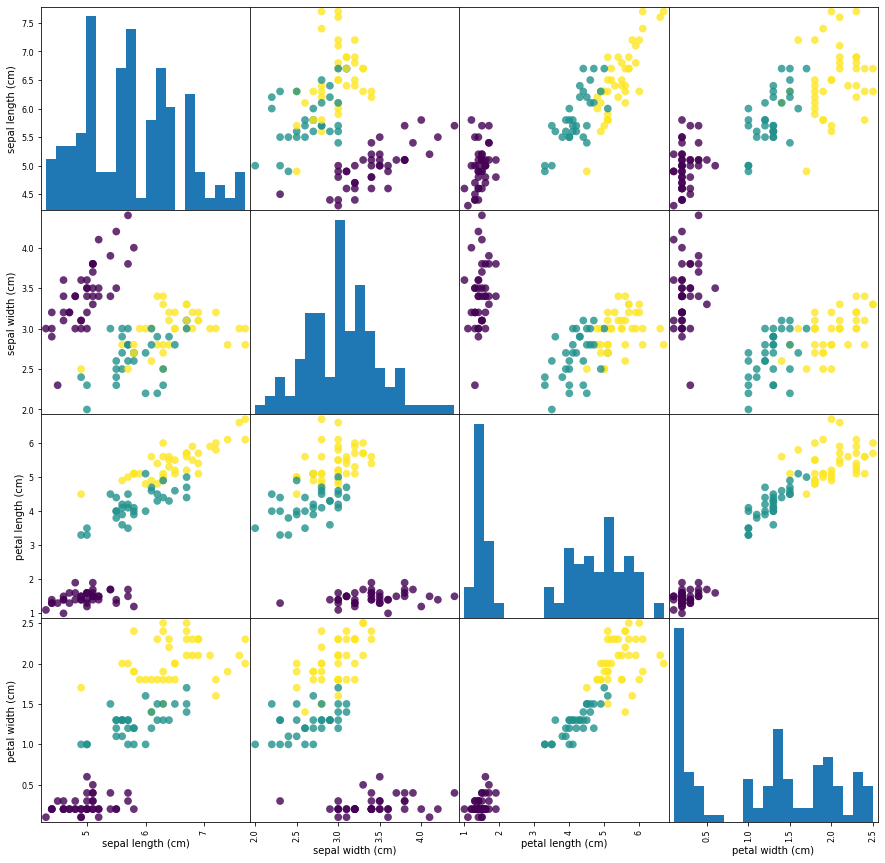

In [15]:
iris_dataframe = pd.DataFrame(X_train, columns=iris.feature_names)
grr = pd.plotting.scatter_matrix(iris_dataframe, c=y_train, figsize=(15, 15), marker='o',hist_kwds={'bins': 20}, s=60, alpha=.8)

0.631578947368421


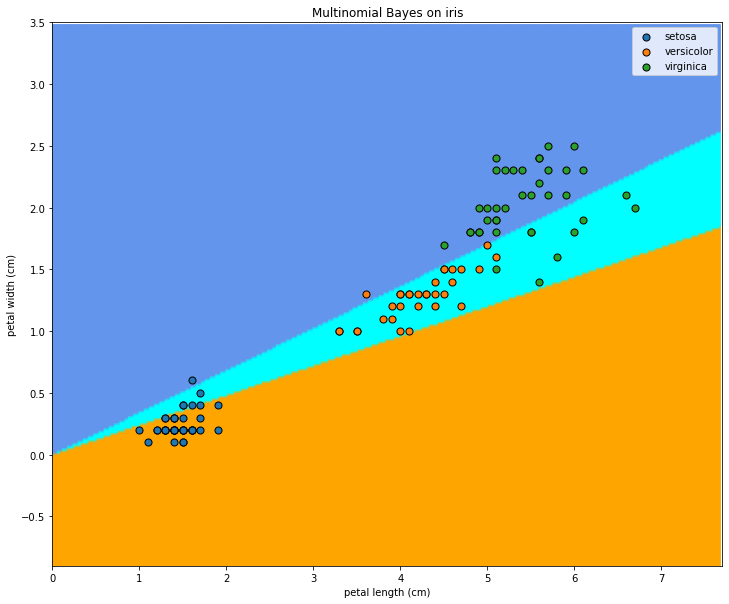

In [16]:
mnb2 = MultinomialNB(alpha=1)
mnb2.fit(X_train[:,2:], y_train)
labelsm2 = mnb2.predict(X_test[:,2:])
scorem2 = accuracy_score(labelsm2, y_test)
print(scorem2)
from matplotlib.colors import ListedColormap

x_min,x_max = X_train[:,2].min() - 1, X_train[:,2].max()+ 1
y_min,y_max = X_train[:,3].min() - 1, X_train[:,3].max()+ 1
h=0.02
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
Z = mnb2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])
cmap_light=ListedColormap(['orange', 'cyan', 'cornflowerblue'])

fig = plt.figure(figsize = (12,10))
ax1 = fig.add_subplot(111)
ax1.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='gouraud')
for target in iris.target_names:
    index=np.where(iris.target_names==target)[0][0]
    ax1.scatter(X_train[:,2][y_train==index],X_train[:,3][y_train==index],
                cmap=cmap_bold,edgecolor='k', s=50, label=target)
ax1.set_xlim(x_min,x_max)
ax1.set_ylim(y_min,y_max)
ax1.legend()
ax1.set_xlabel("petal length (cm)")
ax1.set_ylabel("petal width (cm)")
ax1.set_title("Multinomial Bayes on iris")
plt.show()

20 News Groups Dataset

text dataset.
Bernoulli and Multinomial are trained and tested on this dataset.

In [17]:
data = fetch_20newsgroups()
#data.target_names
categories = data.target_names
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)
#print(train.data[5])

modelm = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=1.0))
modelb = make_pipeline(TfidfVectorizer(), BernoulliNB(alpha=1.0, binarize=1.0))
modelm.fit(train.data, train.target)
modelb.fit(train.data, train.target)
labelsm = modelm.predict(test.data)
labelsb = modelb.predict(test.data)

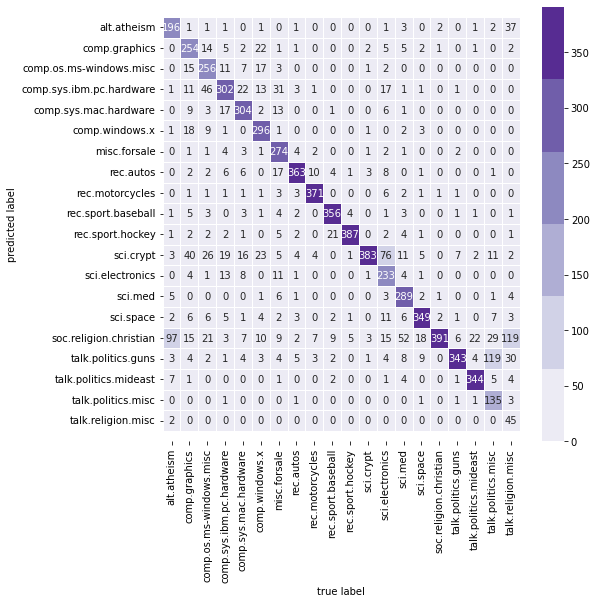

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labelsm)
colormap = sns.color_palette("Purples")
ax = sns.heatmap(mat.T, annot=True, fmt='d', cbar=True, linewidths=1, cmap=colormap, 
            xticklabels=train.target_names, yticklabels=train.target_names)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [19]:
print("Train accuracy of Multinomial NB = %0.5f" % modelm.score(train.data, train.target))
print("Test accuracy of Multinomial NB = %0.5f" % modelm.score(test.data, test.target))
print("Train accuracy of Bernoulli NB = %0.5f" % modelb.score(train.data, train.target))
print("Test accuracy of Bernoulli NB = %0.5f" % modelb.score(test.data, test.target))
print("Training of Multinomial NB: ")
t0 = time()
modelm.fit(train.data, train.target)
t_train_m = time() - t0
print("Training Time: %0.3fs" % t_train_m)

t0 = time()
predm = modelm.predict(test.data)
t_test_m = time() - t0
print("Test Time:  %0.3fs" % t_test_m)

scorem = accuracy_score(test.target, predm)
print("Accuracy:   %0.3f" % scorem)
print("-------")
print("Training of Bernoulli: ")
t0 = time()
modelb.fit(train.data, train.target)
t_train_b = time() - t0
print("Train Time: %0.3fs" % t_train_b)

t0 = time()
predb = modelb.predict(test.data)
t_test_b = time() - t0
print("Test Time:  %0.3fs" % t_test_b)

scoreb = accuracy_score(test.target, predb)
print("Accuracy:   %0.3f" % scoreb)

Train accuracy of Multinomial NB = 0.93928
Test accuracy of Multinomial NB = 0.77947
Train accuracy of Bernoulli NB = 0.53244
Test accuracy of Bernoulli NB = 0.39445
Training of Multinomial NB: 
Training Time: 1.889s
Test Time:  1.088s
Accuracy:   0.779
-------
Training of Bernoulli: 
Train Time: 1.899s
Test Time:  1.088s
Accuracy:   0.394


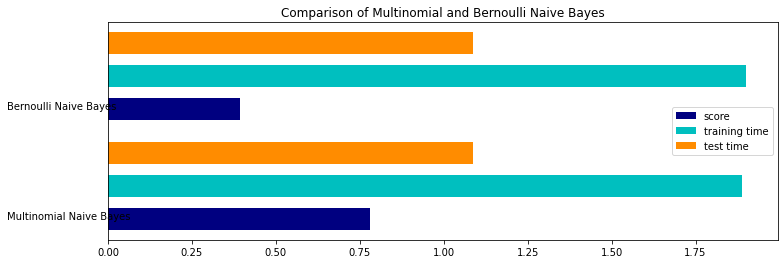

In [20]:
indices = np.arange(2)
clf_names = ["Multinomial Naive Bayes", "Bernoulli Naive Bayes"]
train_time = [t_train_m, t_train_b]
test_time = [t_test_m, t_test_b]
score = [scorem, scoreb]

plt.figure(figsize=(12, 4))
plt.title("Comparison of Multinomial and Bernoulli Naive Bayes")
plt.barh(indices, score, 0.2, label="score", color="navy")
plt.barh(indices + 0.3, train_time, 0.2, label="training time", color="c")
plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()

SMS dataset

text dataset. Multinomial and Bernoulli both trained and tested.

In [21]:
path = 'data/sms.tsv'
features = ['label', 'message']
sms = pd.read_table(path, header=None, names=features)
print(sms.shape)
print(sms.head())
print(sms.label.value_counts())
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
X = sms.message
y = sms.label_num
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

(5572, 2)
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
ham     4825
spam     747
Name: label, dtype: int64


In [22]:
mnb = MultinomialNB(alpha=1)
bnb = BernoulliNB(alpha=1, binarize=1)
mnb.fit(X_train_dtm, y_train)
bnb.fit(X_train_dtm, y_train)
# 4. make class predictions for X_test_dtm
labelsm = mnb.predict(X_test_dtm)
labelsb = bnb.predict(X_test_dtm)
scorem = accuracy_score(labelsm, y_test)
scoreb = accuracy_score(labelsb, y_test)
print("Test accuracy of Multinomial NB = %0.5f" % scorem)
print("Test accuracy of Bernoulli NB = %0.5f" % scoreb)

Test accuracy of Multinomial NB = 0.98205
Test accuracy of Bernoulli NB = 0.98492


<AxesSubplot:>

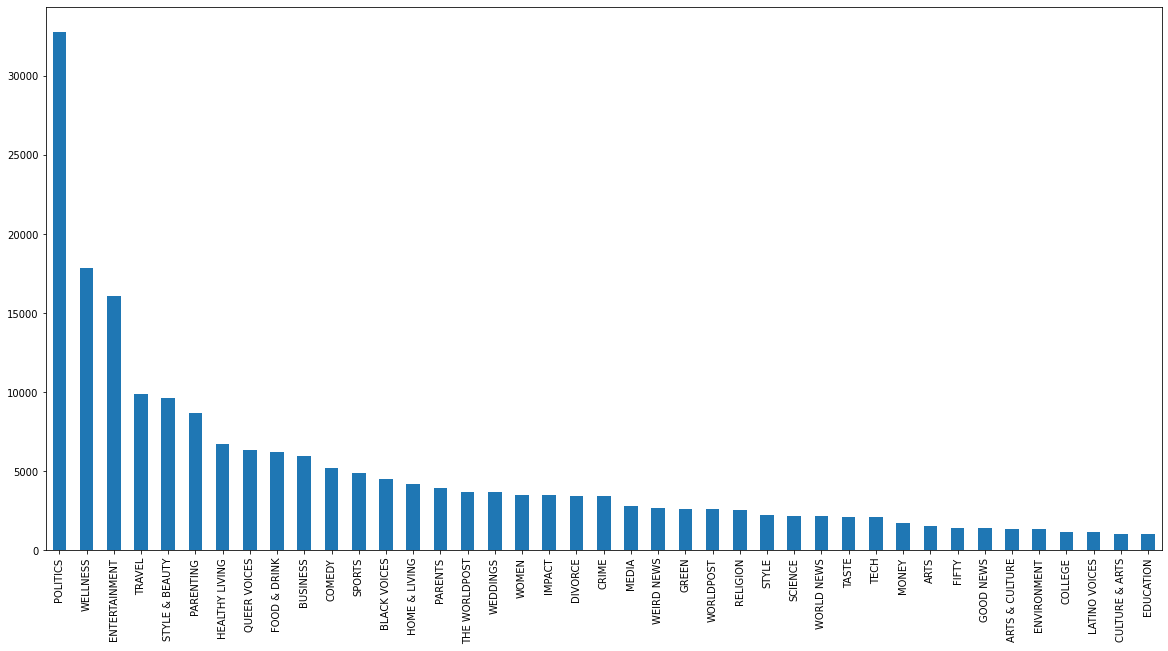

In [23]:
data = pd.read_json('./data/News_Category_Dataset_v2.json', lines=True)
data.head()
data = data[["category", "headline"]]
data.category.value_counts().plot.bar(figsize = (20,10))

In [24]:
mapper = {}
for i,cat in enumerate(data["category"].unique()):
        mapper[cat] = i

data["category_target"] = data["category"].map(mapper)
vect = CountVectorizer(stop_words = 'english')
X_train_matrix = vect.fit_transform(data["headline"]) 
y = data["category_target"]
X_train, X_test, y_train, y_test = train_test_split(X_train_matrix, y, test_size=0.3)
mnb = MultinomialNB(alpha=1)
bnb = BernoulliNB(alpha=1, binarize=1)
mnb.fit(X_train, y_train)
bnb.fit(X_train, y_train)
print (mnb.score(X_train, y_train))
print (mnb.score(X_test, y_test))
print (bnb.score(X_train, y_train))
print (bnb.score(X_test, y_test))
predicted_result=mnb.predict(X_test)

0.6652346778380762
0.5468003186404673
0.4546683072896292
0.41685475305363784
